#### Notebook Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np


# for NLP
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# use for removing HTML tags
from bs4 import BeautifulSoup

# use to craete wordclouds
from wordcloud import WordCloud
from PIL import Image # we will use it to convert image to grayscale and then to array of RGB values

# use for creating training and test data
from sklearn.model_selection import train_test_split

%matplotlib inline


In [3]:
pip install beautifulsoup4

#### Constants

In [153]:
EXAMPLE_FILE = '/content/drive/MyDrive/Machine Learning /Naive Bayes Spam Filter/SpamData/01_Processing/practice_email.txt' # relative path of file

# spam emails
SPAM_1_PATH = '/content/drive/MyDrive/Machine Learning /Naive Bayes Spam Filter/SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = '/content/drive/MyDrive/Machine Learning /Naive Bayes Spam Filter/SpamData/01_Processing/spam_assassin_corpus/spam_2'

# normal emails
EASY_NONSPAM_1_PATH = '/content/drive/MyDrive/Machine Learning /Naive Bayes Spam Filter/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = '/content/drive/MyDrive/Machine Learning /Naive Bayes Spam Filter/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CATEGORY = 1 # is SPAM
HAM_CATEGORY = 0 # is NOT SPAM
VOCAB_SIZE = 2500 # size of vocab list we want to use

# save files 
DATA_JSON_FILE = '/content/drive/MyDrive/Machine Learning /Naive Bayes Spam Filter/SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = '/content/drive/MyDrive/Machine Learning /Naive Bayes Spam Filter/SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = '/content/drive/MyDrive/Machine Learning /Naive Bayes Spam Filter/SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = '/content/drive/MyDrive/Machine Learning /Naive Bayes Spam Filter/SpamData/02_Training/test-data.txt'

# whale wordcloud
WHALE_FILE = '/content/drive/MyDrive/Machine Learning /Naive Bayes Spam Filter/SpamData/01_Processing/wordcloud_resources/whale-icon.png'

# skull wordcloud
SKULL_FILE = '/content/drive/MyDrive/Machine Learning /Naive Bayes Spam Filter/SpamData/01_Processing/wordcloud_resources/skull-icon.png'


# Thumbs up wordcloud for non-spam mail
THUMBS_UP_FILE = '/content/drive/MyDrive/Machine Learning /Naive Bayes Spam Filter/SpamData/01_Processing/wordcloud_resources/thumbs-up.png'

# Thumbs up wordcloud for non-spam mail
THUMBS_DOWN_FILE = '/content/drive/MyDrive/Machine Learning /Naive Bayes Spam Filter/SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

# font file
FONT_FILE = '/content/drive/MyDrive/Machine Learning /Naive Bayes Spam Filter/SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

#### Reading Files

In [5]:
# set up pipeline to read file
stream = open(EXAMPLE_FILE, encoding='latin-1') # open file
message = stream.read() # read file
stream.close() # close file after reading file

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [6]:
stream = open(EXAMPLE_FILE, encoding='latin-1') # open file

is_body = False
lines = [] # lines list, holds all lines

# header and body of email separated by new line
# therefore, change is_body to True, if there is a line that is just new line char
for line in stream:

    # if is_body = True, add line to lines list
    if is_body:
        lines.append(line)

    # if line is = new line char, set is_body to True
    elif line == '\n':
        is_body = True

stream.close() # close file after reading file

# join all individual entries in list with a new line character
# make it more readable
email_body = '\n'.join(lines)

print(email_body)





Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

In [7]:
import sys
sys.getfilesystemencoding() # get default encoding on our machine

'utf-8'

#### Generator Functions

In [8]:
# example

def generate_squares(N):
    for myNumber in range(N):
        yield myNumber ** 2
        
# yield remembers the last point where the function left off and starts from there

In [9]:
generate_squares(3)

<generator object generate_squares at 0x7fb5b81f2950>

In [10]:
for i in generate_squares(5):
    print(i, end=' -> ')

0 -> 1 -> 4 -> 9 -> 16 -> 

In [11]:
for i in generate_squares(5):
    print(i, end=' -> ')

0 -> 1 -> 4 -> 9 -> 16 -> 

#### Email body Extraction

In [12]:
def email_body_generator(path):

    '''
    our os will walk through the file directory tree and
    YIELD us a tuple containing:
       
    the root of the directories, 
    the names of directories,
    and the individual file names 
       '''
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
          
            # generate our file path by JOINING the root and file_name
            # root/file_name
            filepath = join(root, file_name) # find path of file using root dir and filename

            stream = open(filepath, encoding='latin-1') # open file

            is_body = False
            lines = [] # lines list, holds all lines

            # header and body of email separated by new line
            # therefore, change is_body to True, if there is a line that is just new line char
            for line in stream:
              
              # if is_body = True, add line to lines list
              if is_body:
                lines.append(line)

              # if line is = new line char, set is_body to True
              elif line == '\n':
                is_body = True

            stream.close() # close file after reading file

            # join all individual entries in list with a new line character
            # make it more readable
            email_body = '\n'.join(lines)

            yield file_name, email_body


In [13]:
# df = dataframe

'''
df_from_directory(path, classification)

  path: file path
  classification: whether file is SPAM or NOT SPAM

  return value: pandas dataframes containing all the rows, indexed by the 
                row name which is the name of the file 
'''
def df_from_directory(path, classification):

    rows = []
    row_names = []

    # calling generator function in loop
    # provide path to generator function to get file_name and email_body
    for file_name, email_body in email_body_generator(path):

        # create a dictionary from the values that our generator gives us
        # each time loop runs, rows list gets appended with a dictionary
        # dictionary contains 
        #   email body (Message) 
        #   SPAM or NOT SPAM (Classification)
        rows.append({'MESSAGE': email_body, 
                     'CATEGORY': classification})
        
        # each time loop runs, row_names list gets appended with name of file
        row_names.append(file_name)
        
    # return a pandas dataframe 
    return pd.DataFrame(rows, index=row_names)

In [14]:
# all SPAM emails

spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CATEGORY)

# add SPAM_2 to spam emails as well
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CATEGORY))
spam_emails.head()

MESSAGE  CATEGORY
00458.62211764fde0dd7128ea4146268b40dd  Immediate Help Needed.  We are a fortune 500 c...         1
00434.8507c67a652e01636df9b92a0a397193  You can save thousands of dollars over the cou...         1
00292.dbf78a2aaa230d288eb80ab843804252  REGISTER .COM, .BIZ, AND .INFO DOMAINS FOR ONL...         1
00209.5276f967533f2ce0209c1eff631a86ff  This is a multi-part message in MIME format.\n...         1
00216.89c1ede0b81fb09f7334f47a5183410a  This is a multi-part message in MIME format.\n...         1

In [15]:
spam_emails.shape

(1898, 2)

In [16]:
non_spam_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CATEGORY)
non_spam_emails = non_spam_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CATEGORY))

non_spam_emails.shape

(3901, 2)

In [17]:
# combine both span emails dataframe and non-spam emails dataframe

data = pd.concat([spam_emails, non_spam_emails])
print("Shape of entire dataframe is ", data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


MESSAGE  CATEGORY
00458.62211764fde0dd7128ea4146268b40dd  Immediate Help Needed.  We are a fortune 500 c...         1
00434.8507c67a652e01636df9b92a0a397193  You can save thousands of dollars over the cou...         1
00292.dbf78a2aaa230d288eb80ab843804252  REGISTER .COM, .BIZ, AND .INFO DOMAINS FOR ONL...         1
00209.5276f967533f2ce0209c1eff631a86ff  This is a multi-part message in MIME format.\n...         1
00216.89c1ede0b81fb09f7334f47a5183410a  This is a multi-part message in MIME format.\n...         1

In [18]:
data.tail()

MESSAGE  CATEGORY
00604.b79c959719f5f325067852352496e07a  > -----Original Message-----\n\n> From: razor-...         0
00905.defebe39d659693316e71ad1cd70b127  http://www.siliconvalley.com/mld/siliconvalley...         0
00273.3d73db3ab6dc7c9cfc71126ae18b5b1b  On Tue, Aug 06, 2002 at 02:04:11PM +0100, Nial...         0
00749.3500b619df0119e64fc177b3b6eff006  This comment probably goes into better late th...         0
00580.7dd943cb2a791ae9600144dee69f27b1  For the past 2 days, nothing that I'm reportin...         0

In [19]:
'''
Next Few Steps...
    Extract relevant data(email bodies)
    Convert format from txt files to DataFrame
    Check for empty emails
    Check for null or missing values
'''

'\nNext Few Steps...\n    Extract relevant data(email bodies)\n    Convert format from txt files to DataFrame\n    Check for empty emails\n    Check for null or missing values\n'

#### Data Cleaning Checking for Missing Values

In [20]:
# check if any message bodies are null

# data["MESSAGE"].isnull() will show message and T/F for all rows

# data["MESSAGE"].isnull().values will show just the T/F for all rows

# data["MESSAGE"].isnull().values.any() will return boolean if any of the values are missing
  # True if there are missing values
  # False if no missing values

data["MESSAGE"].isnull().values.any()

False

In [21]:
type("") # this does not mean null! 

str

In [22]:
my_var = None

In [23]:
type(my_var) # this is null

NoneType

#### Locate Empty Emails

In [24]:
# locate empty emails by first converting the message into a string


type(data.MESSAGE.str.len() == 0)


pandas.core.series.Series

In [25]:
# T/F if there are ANY emails that are an empty string 
(data.MESSAGE.str.len() == 0).any()

True

In [26]:
# how many emails are there that are an empty string
(data.MESSAGE.str.len() == 0).sum()

3

In [27]:
data[data.MESSAGE.str.len() == 0].index

# cmds is a system file when unzipping a file

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [28]:
# find how many emails have NULL/None values 

data.MESSAGE.isnull().sum()

0

In [29]:
data.shape

(5799, 2)

#### Remove System File Entries from Dataframe

In [30]:
# drop all the system file entries
# access them by their name

# data.drop([nameOfFile])
# by setting inplace=True, we do not have to overwrite our data with new data var
data.drop(['cmds'], inplace=True)


In [31]:
data.shape

(5796, 2)

#### Add Document IDs to Track Emails in Dataset

In [32]:
# add a numerical id to each email (document)

# starts from 0 and goes to len(data) - 1
document_ids = range(0, len(data.index))

# create a new column called DOC_ID that stores document ids
data['DOC_ID'] = document_ids

In [33]:
# create a new column called called file name and set it to index of each email
data['FILE_NAME'] = data.index

# set dataframe index to be the DOC_ID
data.set_index("DOC_ID", inplace=True)
data.head()

MESSAGE  ...                               FILE_NAME
DOC_ID                                                     ...                                        
0       Immediate Help Needed.  We are a fortune 500 c...  ...  00458.62211764fde0dd7128ea4146268b40dd
1       You can save thousands of dollars over the cou...  ...  00434.8507c67a652e01636df9b92a0a397193
2       REGISTER .COM, .BIZ, AND .INFO DOMAINS FOR ONL...  ...  00292.dbf78a2aaa230d288eb80ab843804252
3       This is a multi-part message in MIME format.\n...  ...  00209.5276f967533f2ce0209c1eff631a86ff
4       This is a multi-part message in MIME format.\n...  ...  00216.89c1ede0b81fb09f7334f47a5183410a

[5 rows x 3 columns]

In [34]:
data.tail()

MESSAGE  ...                               FILE_NAME
DOC_ID                                                     ...                                        
5791    > -----Original Message-----\n\n> From: razor-...  ...  00604.b79c959719f5f325067852352496e07a
5792    http://www.siliconvalley.com/mld/siliconvalley...  ...  00905.defebe39d659693316e71ad1cd70b127
5793    On Tue, Aug 06, 2002 at 02:04:11PM +0100, Nial...  ...  00273.3d73db3ab6dc7c9cfc71126ae18b5b1b
5794    This comment probably goes into better late th...  ...  00749.3500b619df0119e64fc177b3b6eff006
5795    For the past 2 days, nothing that I'm reportin...  ...  00580.7dd943cb2a791ae9600144dee69f27b1

[5 rows x 3 columns]

#### Save to File Using Pandas

In [35]:
# save our data to JSON file
data.to_json(DATA_JSON_FILE)

#### Number of Spam Messages Visualised (Pie Charts)

In [36]:
# break down SPAM vs NOT SPAM

# 0 = NOT SPAM
# 1 = SPAM
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [37]:
# store number of spam mails 
amount_of_spam = data.CATEGORY.value_counts()[1] # 1 = access second value in value_counts

# store number of non-spam mails
amount_of_not_spam = data.CATEGORY.value_counts()[0] # 0 = access first value in value_counts

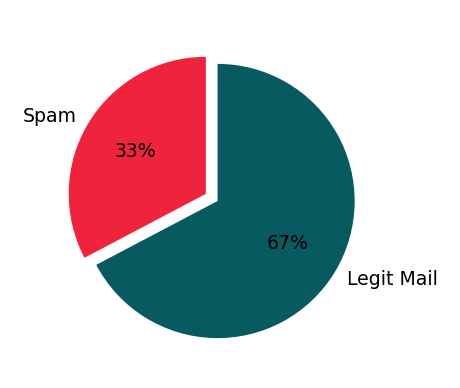

In [38]:
# create pie chart using matplotlib

category_names = ['Spam', 'Legit Mail'] # list of category names
sizes = [amount_of_spam, amount_of_not_spam] # size of slices of pie
colors = ["#ef233c", "#065a60"]

plt.figure(figsize=(2, 2),
           dpi=227) # dpi = resolution
# plot out pie chart
plt.pie(x=sizes, 
        labels=category_names, 
        colors=colors, # set custom colors
        textprops={'fontsize':6}, # set font size
        startangle=90, # rotate chart 90 degrees to give it upright position
        autopct='%1.0f%%', # round to 1 decimal point
        explode=[0, 0.1]) # have spam wedge pop out from graph, list sets offset between two wedges

plt.style.use('dark_background')
plt.show()

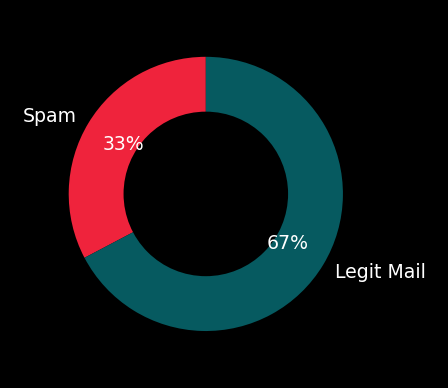

In [39]:
# create donut chart

plt.figure(figsize=(2, 2),
           dpi=227) # dpi = resolution

plt.pie(x=sizes, 
        labels=category_names, 
        colors=colors,
        textprops={'fontsize':6}, 
        startangle=90,
        autopct='%1.0f%%', 
        pctdistance=0.7)

# draw circle
center_circle = plt.Circle((0,0), # circle origin = (0,0)
                           radius=0.6, # circle radius = 0.6
                           fc='black') # creates the black circle in the center

# get current axis, add the circle to our figure
# think this: black circle superimposed on the pie chart to create donut chart
plt.gca().add_artist(center_circle)

plt.style.use('dark_background')
plt.show()

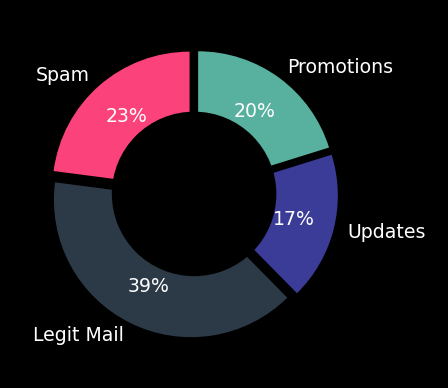

In [40]:
# create donut chart with more than 2 categories

new_category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22] # category_name : size
custom_colors = ['#fc427b', '#2C3A47', '#3B3B98', '#58B19F']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2),
           dpi=227) # dpi = resolution

plt.pie(sizes, 
        labels=new_category_names, 
        textprops={'fontsize':6}, 
        startangle=90,
        autopct='%1.0f%%', 
        colors=custom_colors, 
        pctdistance=0.7, 
        explode=offset)

# draw circle
center_circle = plt.Circle((0,0), radius=0.6, fc='black')
plt.gca().add_artist(center_circle)

plt.style.use('dark_background')
plt.show()

#### Natural Language Processing (NLP)

NLP Use Case Examples:
*   Search
*   Sentiment analysis
*   autocorrect
*   Siri/Alexa

We will use NLP for our Naive Bayes Spam Classifier

NLP will prepare our text for our learning algorithm (Preprocessing)

  How?

1.   Convert everything to lower case for consistency  
2.   Tokenising, meaning that we will split up individual words in a sentence
3.   Remove stop words (i.e: "the, of, am, on, I")
4.   Strip out HTML tags
5.   Word stemming (i.e. "going", "gone", "goes" will all be treated as "go"
6.   Remove Punctuation











##### Text Processing

##### Download the NLTK Resources (Tokenizer & Stopwords)

NLTK: Natural Langauge Tool Kit

In [41]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [42]:
# download stop words 

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [43]:
# download some sample texts

nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package shakespeare to /root/nltk_data...
[nltk_data]   Unzipping corpora/shakespeare.zip.


True

##### Tokenising

In [44]:
# split the msg into seperate words and turn into lowercase

msg = "All work and no play makes Jack a dull boy."
# word_tokenize(msg.lower())

In [45]:
# set is an unordered, immutable collection
# does not allow for duplicates
# therefore, useful for checking membership

stop_words = set(stopwords.words('english')) # set of all stop words in english

In [46]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [47]:
# check for membership using "in" keyword
if 'lost' in stop_words:
    print("Found it")
else:
    print("not in here")

not in here


In [48]:
# make output lowercase, tokenize, and eliminate stop words

msg = "All work and no play makes Jack a dull boy. To be or not to be."

tokenized_lc_words = word_tokenize(msg.lower()) # tokenise and lowercase

# list of filtered word, that are tokenised, lower-cased, and are not stop words
filtered_words = [word for word in tokenized_lc_words if word not in stop_words]

filtered_words

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']

##### Word Stems and Stemming

In [49]:
'''
word stemming
treat all derived and base words the same way

Examples:
fisher, fishing, fishy = fish
goes, going, gone = go
arguing, argue, arguement = argu (not a typo)

reduce all derived words down to the base word

'''

msg = "All work and no play makes Jack a dull boy. To be or not to be \
      Nobody expects the Spanish Inquisition!"
tokenized_lc_words = word_tokenize(msg.lower())

# de-facto Stemmer for English
stemmer = PorterStemmer()

# use SnowballStemmer to choose language

# list of filtered word, that are tokenised, lower-cased, are not stop words, and stemmed
filtered_words = [stemmer.stem(word) for word in tokenized_lc_words if word not in stop_words]

In [50]:
# stemmed words
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


##### Removing Punctuation

In [51]:
# remove punctuation

msg = "All work and no play makes Jack a dull boy. To be or not to be. ???\
Nobody expects the Spanish Inquisition!"
tokenized_lc_words = word_tokenize(msg.lower())

stemmer = PorterStemmer()
# use SnowballStemmer to choose language

# list of filtered word, that are tokenised, lower-cased, are not stop words, stemmed, and punctuation removed
filtered_words = [stemmer.stem(word) for word in tokenized_lc_words 
                  if word not in stop_words and word.isalpha()]

In [52]:
# punctuation removed

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


##### Removing HTML Tags from Emails

In [53]:
# view email in readable format using BeautifulSoup

soup = BeautifulSoup(data.at[2,'MESSAGE'], 'html.parser')
print(soup.prettify())

REGISTER .COM, .BIZ, AND .INFO DOMAINS FOR ONLY $14.95





The new domain names are finally available to the general public at discount prices. Now you can register one of the exciting new .BIZ or .INFO domain names, as well as the original .COM and .NET names for just $14.95. These brand new domain extensions were recently approved by ICANN and have the same rights as the original .COM and .NET domain names. The biggest benefit is of-course that the .BIZ and .INFO domain names are currently more available. i.e. it will be much easier to register an attractive and easy-to-remember domain name for the same price.  Visit: http://www.domainsforeveryone.com/ today for more info.

 

Register your domain name today for just $14.95 at: http://www.domainsforeveryone.com/  Registration fees include full access to an easy-to-use control panel to manage your domain name in the future.

 

Sincerely,

 

Domain Administrator

Domains For Everyone





To remove your email address from further pr

In [54]:
# Remove html tags using BeautifulSoup

soup.get_text() # remove html tags

"REGISTER .COM, .BIZ, AND .INFO DOMAINS FOR ONLY $14.95\n\n\n\n\n\nThe new domain names are finally available to the general public at discount prices. Now you can register one of the exciting new .BIZ or .INFO domain names, as well as the original .COM and .NET names for just $14.95. These brand new domain extensions were recently approved by ICANN and have the same rights as the original .COM and .NET domain names. The biggest benefit is of-course that the .BIZ and .INFO domain names are currently more available. i.e. it will be much easier to register an attractive and easy-to-remember domain name for the same price.  Visit: http://www.domainsforeveryone.com/ today for more info.\n\n \n\nRegister your domain name today for just $14.95 at: http://www.domainsforeveryone.com/  Registration fees include full access to an easy-to-use control panel to manage your domain name in the future.\n\n \n\nSincerely,\n\n \n\nDomain Administrator\n\nDomains For Everyone\n\n\n\n\n\nTo remove your em

##### Functions for Email Processing

In [55]:
'''
clean_message(message, stemmer=PorterStemmer(),
                 stop_words=set(stopwords.words('english'))

  message: REQUIRED
           email body

  stemmer: OPTIONAL
           which stemmer are you using
           default=PorterStemmer()
  
  stop_words: OPTIONAL
              set of stop words
              default = set of stop words in English

  return value: list of filtered words that are lowercased, stemmed, 
                and do not have any stop words or punctuation
                 
'''

def clean_message(message, stemmer=PorterStemmer(),
                 stop_words=set(stopwords.words('english'))):
    
    
    soup = BeautifulSoup(message, 'html.parser') # Remove HTML tags
    cleaned_text = soup.get_text() # save HTML-free email to new variable
    
    # Converts to Lower Case and Tokenizes(splits up) the message
    tokenized_lc_words = word_tokenize(cleaned_text.lower())
    
    # Removed stop words, punctuation, and gets word stems
    filtered_words = [stemmer.stem(word) for word in tokenized_lc_words 
                  if word not in stop_words and word.isalpha()]
    
    
    
    return filtered_words

In [56]:
clean_message(data.at[2, 'MESSAGE'])

['regist',
 'domain',
 'new',
 'domain',
 'name',
 'final',
 'avail',
 'gener',
 'public',
 'discount',
 'price',
 'regist',
 'one',
 'excit',
 'new',
 'domain',
 'name',
 'well',
 'origin',
 'name',
 'brand',
 'new',
 'domain',
 'extens',
 'recent',
 'approv',
 'icann',
 'right',
 'origin',
 'domain',
 'name',
 'biggest',
 'benefit',
 'domain',
 'name',
 'current',
 'avail',
 'much',
 'easier',
 'regist',
 'attract',
 'domain',
 'name',
 'price',
 'visit',
 'http',
 'today',
 'info',
 'regist',
 'domain',
 'name',
 'today',
 'http',
 'registr',
 'fee',
 'includ',
 'full',
 'access',
 'control',
 'panel',
 'manag',
 'domain',
 'name',
 'futur',
 'sincer',
 'domain',
 'administr',
 'domain',
 'everyon',
 'remov',
 'email',
 'address',
 'promot',
 'mail',
 'compani',
 'click',
 'http',
 'irish',
 'linux',
 'user',
 'group',
 'ilug',
 'http',
 'un',
 'subscript',
 'inform',
 'list',
 'maintain',
 'listmast']

##### Apply Cleaning and Tokenisation to all messages

###### Slicing Dataframs and Series & Creating Subsets

In [57]:
data.at[2, 'MESSAGE'] # name-based lookup
data.iat[2, 2] # integer-based lookup

'00292.dbf78a2aaa230d288eb80ab843804252'

In [58]:
data.iloc[0:2] # output first two rows

MESSAGE  ...                               FILE_NAME
DOC_ID                                                     ...                                        
0       Immediate Help Needed.  We are a fortune 500 c...  ...  00458.62211764fde0dd7128ea4146268b40dd
1       You can save thousands of dollars over the cou...  ...  00434.8507c67a652e01636df9b92a0a397193

[2 rows x 3 columns]

In [59]:
# iloc also works on Series
first_emails = data.MESSAGE.iloc[0:3]

# apply clean_message function on first_emails Series
nested_lst = first_emails.apply(clean_message) 

In [60]:
print(nested_lst[0]) # sublist within nested_lst

print(nested_lst)

['immedi', 'help', 'need', 'fortun', 'compani', 'grow', 'tremend', 'rate', 'per', 'year', 'simpli', 'keep', 'look', 'motiv', 'individu', 'look', 'earn', 'substanti', 'incom', 'work', 'home', 'real', 'opportun', 'make', 'excel', 'incom', 'home', 'experi', 'requir', 'provid', 'train', 'may', 'need', 'look', 'energet', 'self', 'motiv', 'peopl', 'click', 'link', 'complet', 'onlin', 'inform', 'request', 'form', 'one', 'employ', 'specialist', 'contact', 'http', 'look', 'employ', 'home', 'career', 'provid', 'vast', 'opportun', 'substanti', 'incom', 'pleas', 'fill', 'onlin', 'inform', 'request', 'form', 'http', 'remov', 'list', 'simpli', 'click', 'link', 'http']
DOC_ID
0    [immedi, help, need, fortun, compani, grow, tr...
1    [save, thousand, dollar, cours, loan, drop, ra...
2    [regist, domain, new, domain, name, final, ava...
Name: MESSAGE, dtype: object


In [61]:
# flatten a nested lst

def flatten_lst(nested_lst):


  flattened_lst = []

  for sublst in nested_lst:

    for item in sublst:

      flattened_lst.append(item)

  return flattened_lst

In [62]:
# flatten our nested list by adding individual items of each sublist to flattened list

flattened_lst = flatten_lst(nested_lst)

# could do this with list comprehension but loses readability with nested loops
# flattened_lst = [item for sublist in nested_lst for item in sublist]

In [63]:
len(flattened_lst)

242

In [64]:
# use apply() on all messages in the dataframe
nested_lst = data.MESSAGE.apply(clean_message)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [65]:
nested_lst.head

<bound method NDFrame.head of DOC_ID
0       [immedi, help, need, fortun, compani, grow, tr...
1       [save, thousand, dollar, cours, loan, drop, ra...
2       [regist, domain, new, domain, name, final, ava...
3       [messag, mime, format, high, veloc, term, unde...
4       [messag, mime, format, bassey, associ, falomo,...
                              ...                        
5791    [messag, mailto, behalf, craig, thursday, augu...
5792    [http, post, thu, jul, copyright, law, thwart,...
5793    [tue, aug, niall, bradi, wrote, guess, inspir,...
5794    [comment, probabl, goe, better, late, never, w...
5795    [past, day, noth, report, seem, databas, repor...
Name: MESSAGE, Length: 5796, dtype: object>

In [66]:
nested_lst.tail

<bound method NDFrame.tail of DOC_ID
0       [immedi, help, need, fortun, compani, grow, tr...
1       [save, thousand, dollar, cours, loan, drop, ra...
2       [regist, domain, new, domain, name, final, ava...
3       [messag, mime, format, high, veloc, term, unde...
4       [messag, mime, format, bassey, associ, falomo,...
                              ...                        
5791    [messag, mailto, behalf, craig, thursday, augu...
5792    [http, post, thu, jul, copyright, law, thwart,...
5793    [tue, aug, niall, bradi, wrote, guess, inspir,...
5794    [comment, probabl, goe, better, late, never, w...
5795    [past, day, noth, report, seem, databas, repor...
Name: MESSAGE, Length: 5796, dtype: object>

###### Using Logic to Slice Dataframes

In [67]:
data[data.CATEGORY == 1] # only return rows where Category = 1 (is Spam)

MESSAGE  ...                               FILE_NAME
DOC_ID                                                     ...                                        
0       Immediate Help Needed.  We are a fortune 500 c...  ...  00458.62211764fde0dd7128ea4146268b40dd
1       You can save thousands of dollars over the cou...  ...  00434.8507c67a652e01636df9b92a0a397193
2       REGISTER .COM, .BIZ, AND .INFO DOMAINS FOR ONL...  ...  00292.dbf78a2aaa230d288eb80ab843804252
3       This is a multi-part message in MIME format.\n...  ...  00209.5276f967533f2ce0209c1eff631a86ff
4       This is a multi-part message in MIME format.\n...  ...  00216.89c1ede0b81fb09f7334f47a5183410a
...                                                   ...  ...                                     ...
1891    <html>\n\n<body>\n\n<div align="center">\n\n<c...  ...  00328.47ba83d868220761b2ff71ce39d91a37
1892    <HTML>\n\n<body bgcolor=#FFFFFF>\n\n<font colo...  ...  00281.d5147756d766fba6dbc649f786e38bc2
1893    <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0//E...  ...  00268.a9bc047709bc6362328d3b72998956f2
1894    <html>\n\n\n\n<head>\n\n<meta http-equiv="Cont...  ...  00622.7c8edc50203f6a2dc87e97e9eefddce7
1895    <html>\n\n\n\n<head>\n\n<meta http-equiv=3D"Co...  ...  00450.acfa2d7f64e43ef04600e30fdecff8ec

[1896 rows x 3 columns]

In [68]:
doc_ids_spam = data[data.CATEGORY == 1].index # store the indices of all Spam emails

doc_ids_ham = data[data.CATEGORY == 0].index # store the indices of all non-Spam emails

###### Subsetting a Series with an Index

In [69]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [70]:
type(nested_lst)

pandas.core.series.Series

In [71]:
nested_lst_ham = nested_lst.loc[doc_ids_ham] # subset of all non-Spam emails

In [72]:
nested_lst_spam = nested_lst.loc[doc_ids_spam] # subset of all Spam emails

In [73]:
nested_lst_ham

DOC_ID
1896    [guido, therefor, propos, nuke, ad, featur, gu...
1897    [rob, windsor, david, dietz, latest, propos, d...
1898    [subject, line, indic, sure, stupid, question,...
1899    [tp, tim, peter, write, tp, jeremi, hylton, to...
1900    [get, far, road, peopl, think, creat, spambay,...
                              ...                        
5791    [messag, mailto, behalf, craig, thursday, augu...
5792    [http, post, thu, jul, copyright, law, thwart,...
5793    [tue, aug, niall, bradi, wrote, guess, inspir,...
5794    [comment, probabl, goe, better, late, never, w...
5795    [past, day, noth, report, seem, databas, repor...
Name: MESSAGE, Length: 3900, dtype: object

In [74]:
nested_lst_spam

DOC_ID
0       [immedi, help, need, fortun, compani, grow, tr...
1       [save, thousand, dollar, cours, loan, drop, ra...
2       [regist, domain, new, domain, name, final, ava...
3       [messag, mime, format, high, veloc, term, unde...
4       [messag, mime, format, bassey, associ, falomo,...
                              ...                        
1891    [shop, hundr, lender, one, click, step, answer...
1892    [limit, time, offer, quick, perfect, breast, e...
1893    [quotepool, td, verdana, tahoma, color, black,...
1894    [exclus, offer, exclus, offer, search, vehicl,...
1895    [job, search, time, new, roman, center, avoid,...
Name: MESSAGE, Length: 1896, dtype: object

In [75]:

# calculate the total number of words in spam emails
spam_emails_words_len = len([item for sublst in nested_lst_spam for item in sublst])

# calculate the total number of words in non-spam emails
ham_emails_words_len = len([item for sublst in nested_lst_ham for item in sublst])


In [76]:
spam_emails_words_len

320515

In [77]:
ham_emails_words_len

441164

In [78]:
def find_most_common_words(nested_lst, top_n=10):

  flattened_lst = flatten_lst(nested_lst) # first flatten nested spam list
  series_of_words = pd.Series(flattened_lst) # convert to pandas Series

  return series_of_words.value_counts()[0:top_n] # return top n common words


In [79]:
# find 10 most common words in spam emails
find_most_common_words(nested_lst_spam, top_n=10)

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

In [80]:
# find 10 most common words in non-spam emails
find_most_common_words(nested_lst_ham, top_n=10)

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

##### Creating a Word Cloud

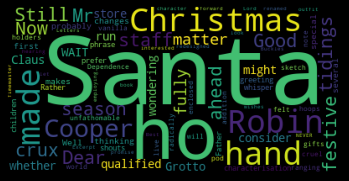

In [81]:
word_cloud = WordCloud().generate(email_body) # create word cloud from email body

plt.imshow(word_cloud) # display data as an image

plt.axis('off') # turn off axis

plt.show() 

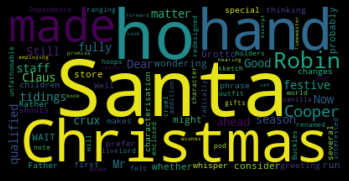

In [82]:
word_cloud = WordCloud().generate(email_body)

plt.imshow(word_cloud,
           interpolation='bilinear')

plt.axis('off')

plt.show()

In [83]:

# corpus of melville moby dick
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')

len(example_corpus)

260819

In [84]:
word_lst = [''.join(word) for word in example_corpus]

In [85]:
word_lst

['[',
 'Moby',
 'Dick',
 'by',
 'Herman',
 'Melville',
 '1851',
 ']',
 'ETYMOLOGY',
 '.',
 '(',
 'Supplied',
 'by',
 'a',
 'Late',
 'Consumptive',
 'Usher',
 'to',
 'a',
 'Grammar',
 'School',
 ')',
 'The',
 'pale',
 'Usher',
 '--',
 'threadbare',
 'in',
 'coat',
 ',',
 'heart',
 ',',
 'body',
 ',',
 'and',
 'brain',
 ';',
 'I',
 'see',
 'him',
 'now',
 '.',
 'He',
 'was',
 'ever',
 'dusting',
 'his',
 'old',
 'lexicons',
 'and',
 'grammars',
 ',',
 'with',
 'a',
 'queer',
 'handkerchief',
 ',',
 'mockingly',
 'embellished',
 'with',
 'all',
 'the',
 'gay',
 'flags',
 'of',
 'all',
 'the',
 'known',
 'nations',
 'of',
 'the',
 'world',
 '.',
 'He',
 'loved',
 'to',
 'dust',
 'his',
 'old',
 'grammars',
 ';',
 'it',
 'somehow',
 'mildly',
 'reminded',
 'him',
 'of',
 'his',
 'mortality',
 '.',
 '"',
 'While',
 'you',
 'take',
 'in',
 'hand',
 'to',
 'school',
 'others',
 ',',
 'and',
 'to',
 'teach',
 'them',
 'by',
 'what',
 'name',
 'a',
 'whale',
 '-',
 'fish',
 'is',
 'to',
 'be',
 

In [86]:
# display the entire novel as a string

'''
we need to convert to string as wordCloud expects a simple string argument
'''
novel_as_string = ' '.join(word_lst)

In [87]:
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

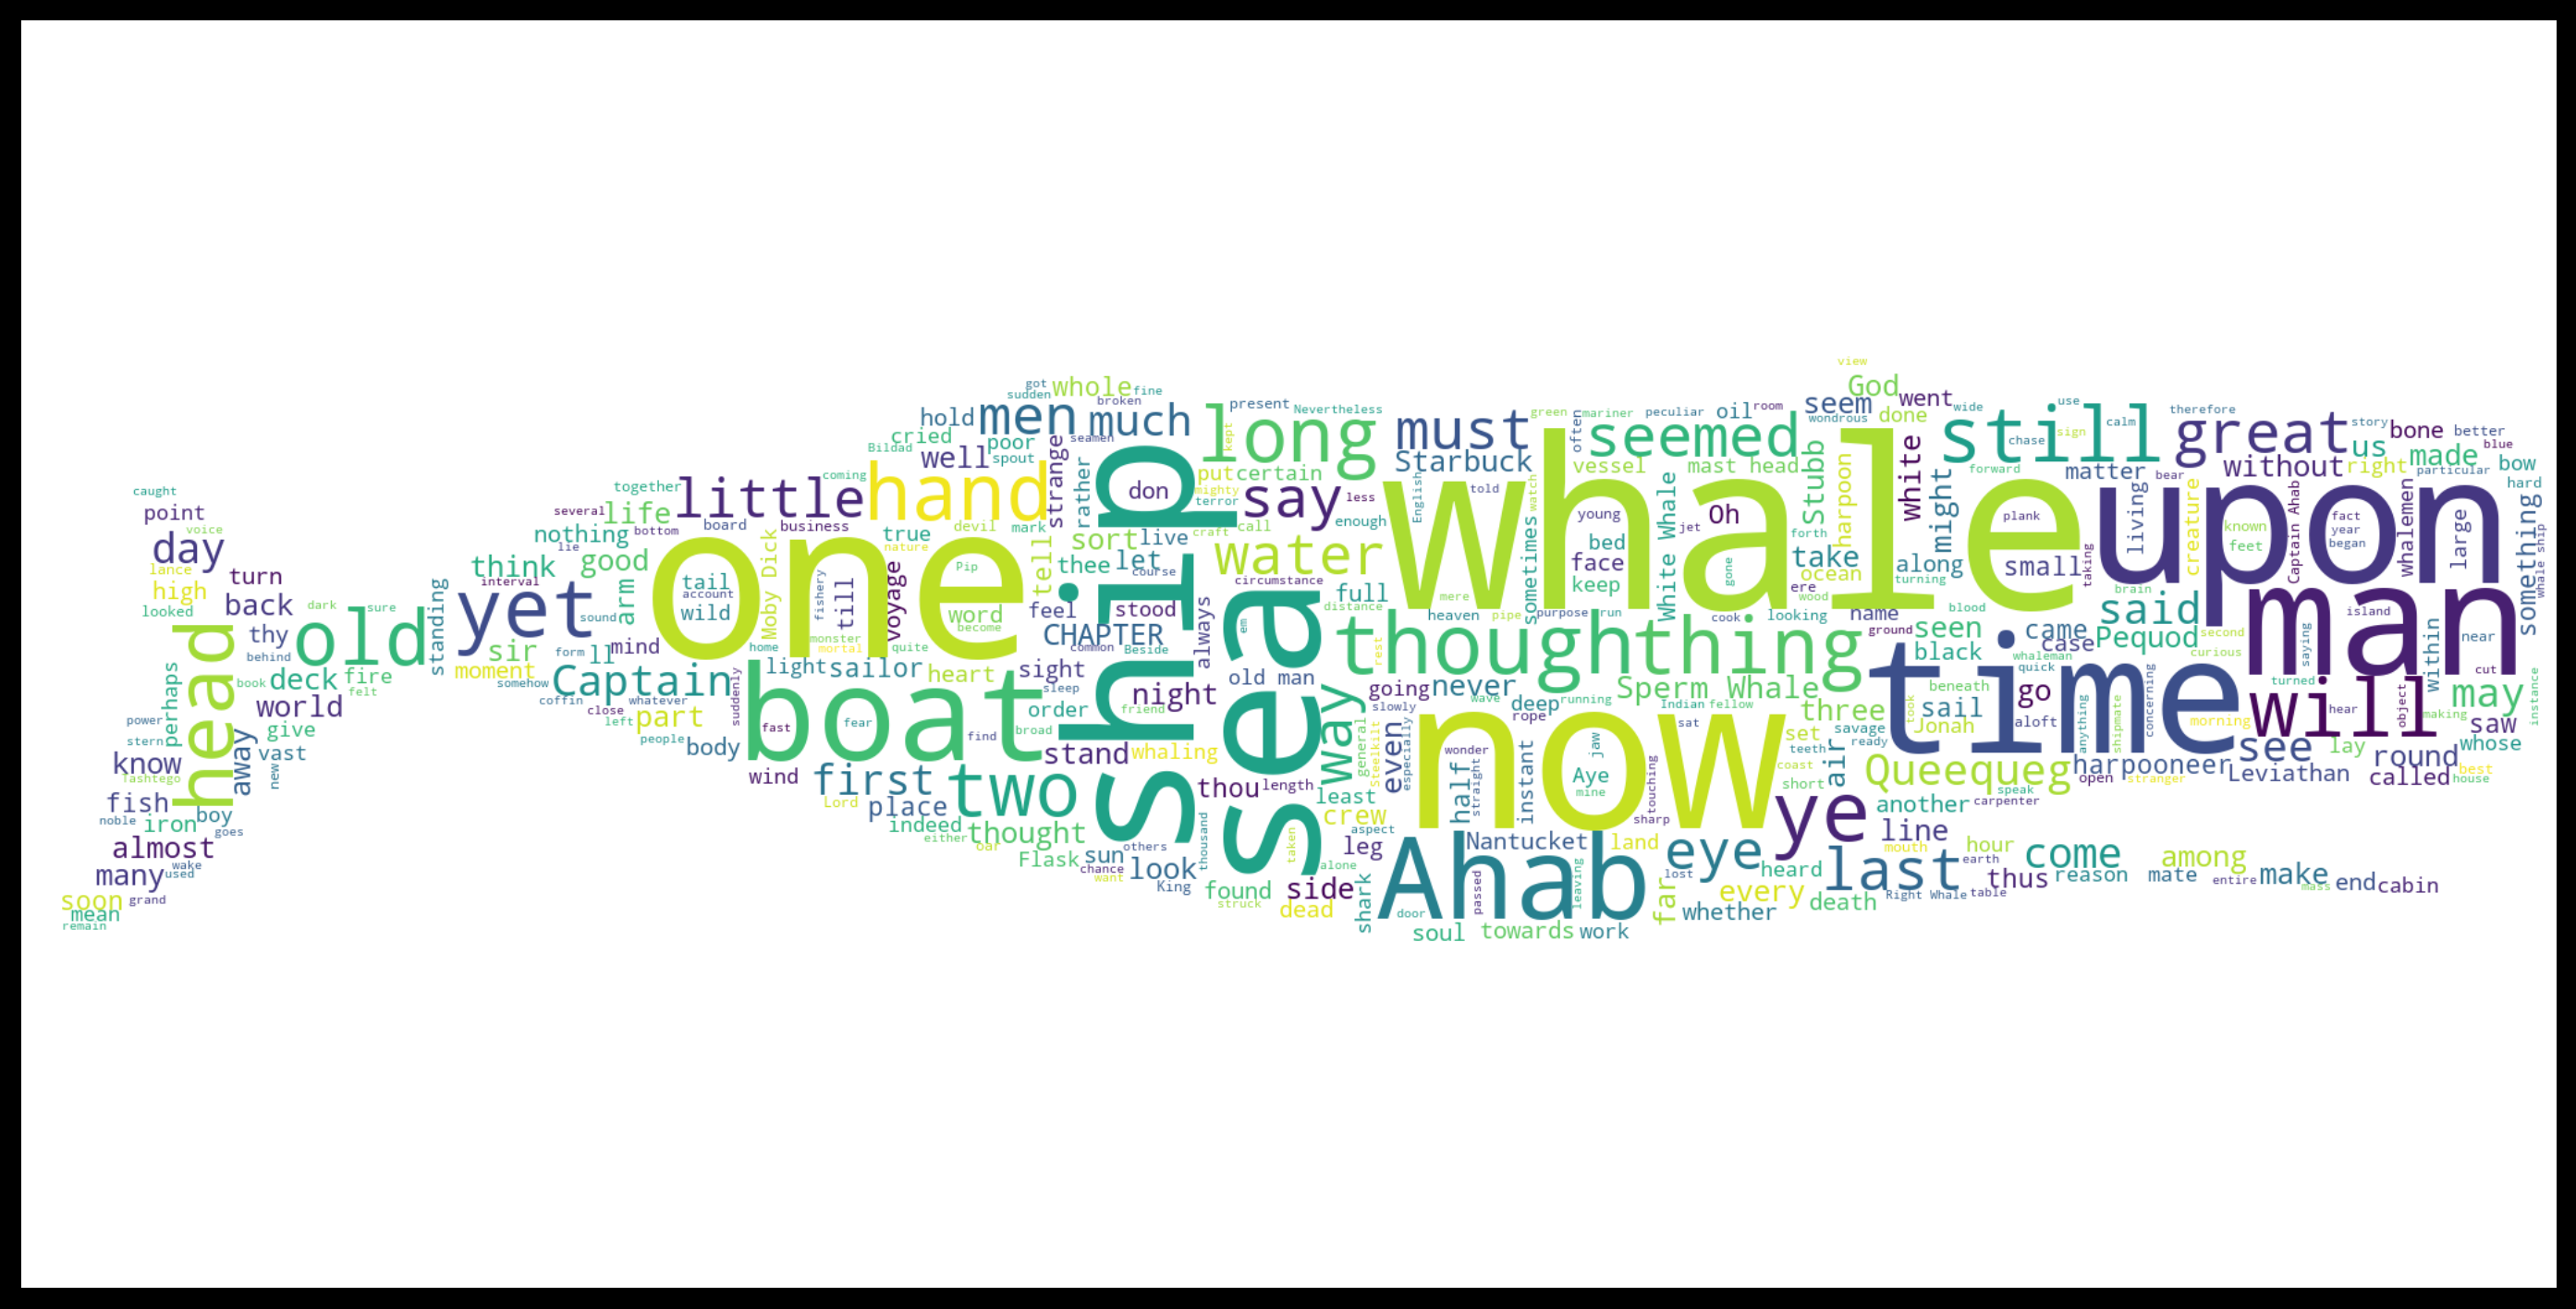

In [88]:
icon = Image.open(WHALE_FILE) # open our image using PIL.Image

# our blank canvas
# will result in a white silhoutte of image
image_mask = Image.new(mode='RGB', # rgb mode
          size=icon.size, # size = size of our original image 
          color=(255, 255, 255)) # color = white

# paste image on to blank canvas
image_mask.paste(icon, box=icon)

# convert image object to rgb array
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, # mask is our rgb array 
                       background_color='white', # background color = white
                       max_words=400) 

word_cloud.generate(novel_as_string)

plt.figure(figsize=([16, 8]),
           dpi=227) # dpi = resolution

plt.imshow(word_cloud,
           interpolation='bilinear')

plt.axis('off')

plt.show()

In [89]:
rgb_array.shape # whale icon is 1024 x 2048, 3 columns (r g b)

(1024, 2048, 3)

In [90]:
# corpus of hamlet shakespeare 
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')

len(hamlet_corpus)

37360

In [91]:
hamlet_words_lst = [''.join(word) for word in hamlet_corpus]

In [92]:
hamlet_words_str = ' '.join(hamlet_words_lst)

In [93]:
hamlet_words_str

"[ The Tragedie of Hamlet by William Shakespeare 1599 ] Actus Primus . Scoena Prima . Enter Barnardo and Francisco two Centinels . Barnardo . Who ' s there ? Fran . Nay answer me : Stand & vnfold your selfe Bar . Long liue the King Fran . Barnardo ? Bar . He Fran . You come most carefully vpon your houre Bar . ' Tis now strook twelue , get thee to bed Francisco Fran . For this releefe much thankes : ' Tis bitter cold , And I am sicke at heart Barn . Haue you had quiet Guard ? Fran . Not a Mouse stirring Barn . Well , goodnight . If you do meet Horatio and Marcellus , the Riuals of my Watch , bid them make hast . Enter Horatio and Marcellus . Fran . I thinke I heare them . Stand : who ' s there ? Hor . Friends to this ground Mar . And Leige - men to the Dane Fran . Giue you good night Mar . O farwel honest Soldier , who hath relieu ' d you ? Fra . Barnardo ha ' s my place : giue you goodnight . Exit Fran . Mar . Holla Barnardo Bar . Say , what is Horatio there ? Hor . A peece of him Bar

In [94]:
print(hamlet_words_str)

[ The Tragedie of Hamlet by William Shakespeare 1599 ] Actus Primus . Scoena Prima . Enter Barnardo and Francisco two Centinels . Barnardo . Who ' s there ? Fran . Nay answer me : Stand & vnfold your selfe Bar . Long liue the King Fran . Barnardo ? Bar . He Fran . You come most carefully vpon your houre Bar . ' Tis now strook twelue , get thee to bed Francisco Fran . For this releefe much thankes : ' Tis bitter cold , And I am sicke at heart Barn . Haue you had quiet Guard ? Fran . Not a Mouse stirring Barn . Well , goodnight . If you do meet Horatio and Marcellus , the Riuals of my Watch , bid them make hast . Enter Horatio and Marcellus . Fran . I thinke I heare them . Stand : who ' s there ? Hor . Friends to this ground Mar . And Leige - men to the Dane Fran . Giue you good night Mar . O farwel honest Soldier , who hath relieu ' d you ? Fra . Barnardo ha ' s my place : giue you goodnight . Exit Fran . Mar . Holla Barnardo Bar . Say , what is Horatio there ? Hor . A peece of him Bar 

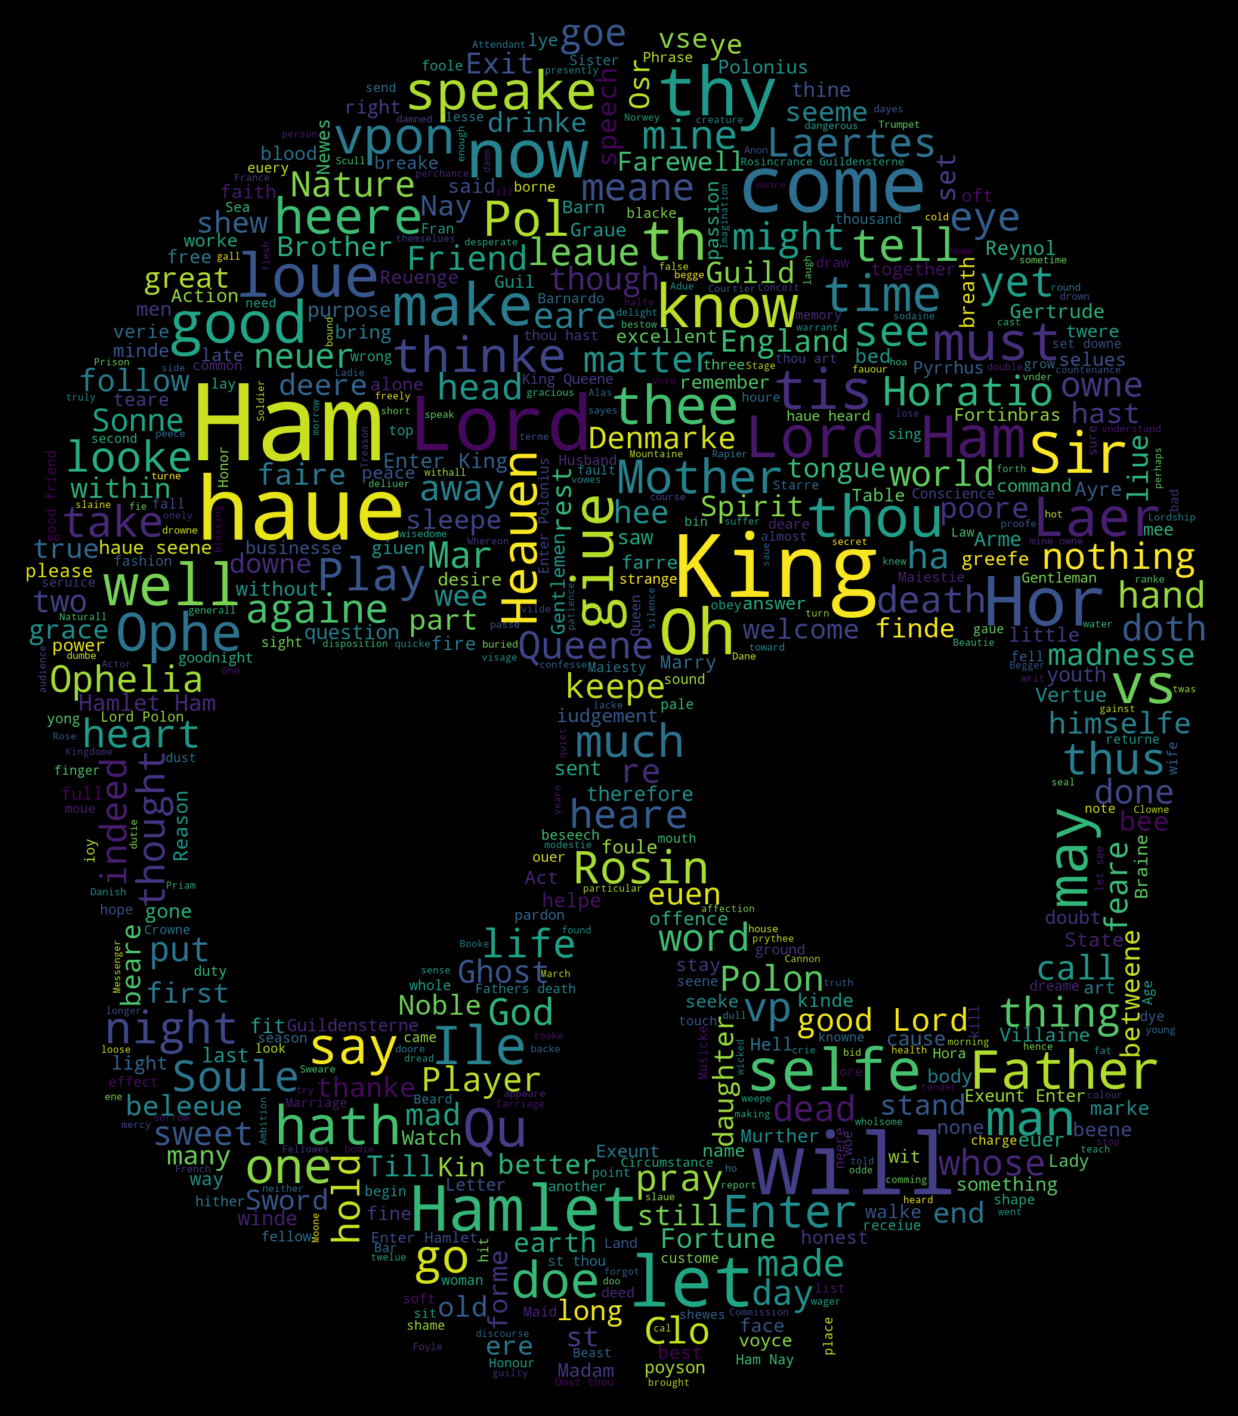

In [95]:
new_icon = Image.open(SKULL_FILE) # open our image using PIL.Image

# our blank canvas
# will result in a white silhoutte of image
new_image_mask = Image.new(mode='RGB', # rgb mode
          size=new_icon.size, # size = size of our original image 
          color=(255, 255, 255)) # color = white

# paste image on to blank canvas
new_image_mask.paste(new_icon, box=new_icon)

# convert image object to rgb array
new_rgb_array = np.array(new_image_mask)

new_word_cloud = WordCloud(mask=new_rgb_array, # mask is our rgb array 
                       background_color='black', # background color = white
                       max_words=600) 

new_word_cloud.generate(hamlet_words_str)

plt.figure(figsize=([16, 8]),
           dpi=227) # dpi = resolution

plt.imshow(new_word_cloud,
           interpolation='bilinear')

plt.axis('off') # remove axis

plt.show()

###### Creating Word Clouds for Emails

In [96]:
# first flatten nested spam lists and non-spam lists

flattened_spam_lst = flatten_lst(nested_lst_spam)
flattened_ham_lst = flatten_lst(nested_lst_ham)

In [97]:
# next, convert the flattened lists into strings

spam_emails_str = ' '.join(flattened_spam_lst)
ham_emails_str = ' '.join(flattened_ham_lst)

In [98]:
'''
create_wordCloud(words_str, mask_img=None, mask_color=(255, 255, 255), 
                     background_color='black', max_words=200,
                     figsize=[16, 8], resolution=227,
                     interpolation='bilinear'):

  words_str: REQUIRED
             string of words to create word cloud out of

  mask_img: OPTIONAL
            image of mask word cloud should be 
            default=None, no mask

  mask_color: OPTIONAL
              rgb tuple of mask colors
              default=(255, 255, 255), white

  font_path: OPTIONAL
             file path of desired font
             default=None

  colormap: OPTIONAL
            matplotlib color scheme
            default=None (virdis)
  
  background_color: OPTIONAL
                    background color of word cloud
                    default=black
  
  max_words: OPTIONAL
             max number of words in word cloud
             default=200

  figsize: OPTIONAL
           dimensions of figure
           default=[16,8]

  resolution: OPTIONAL
              resolution of the graph (dpi)
              default=227
  
  interpolation: OPTIONAL
                 type of interpolation on image
                 default='bilinear'


  return value: None, display word cloud 
                 
'''



def create_wordCloud(words_str, mask_img=None, mask_color=(255, 255, 255), 
                     font_path=None, colormap=None, background_color='black', max_words=200,
                     figsize=[16, 8], resolution=227,
                     interpolation='bilinear'):
  
  new_icon = Image.open(mask_img) # open our image using PIL.Image

  # our blank canvas
  # will result in a white silhoutte of image
  new_image_mask = Image.new(mode='RGB', # rgb mode
            size=new_icon.size, # size = size of our original image 
            color=mask_color) # color = white

  # paste image on to blank canvas
  new_image_mask.paste(new_icon, box=new_icon)

  # convert image object to rgb array
  new_rgb_array = np.array(new_image_mask)

  new_word_cloud = WordCloud(font_path=font_path, # font that you want to use 
                             mask=new_rgb_array, # mask is our rgb array 
                        background_color=background_color, # background color = white
                        max_words=max_words,
                        colormap=colormap) 

  new_word_cloud.generate(words_str.upper())

  plt.figure(figsize=(figsize),
            dpi=resolution) # dpi = resolution

  plt.imshow(new_word_cloud,
            interpolation=interpolation)

  plt.axis('off') # remove axis

  plt.show()

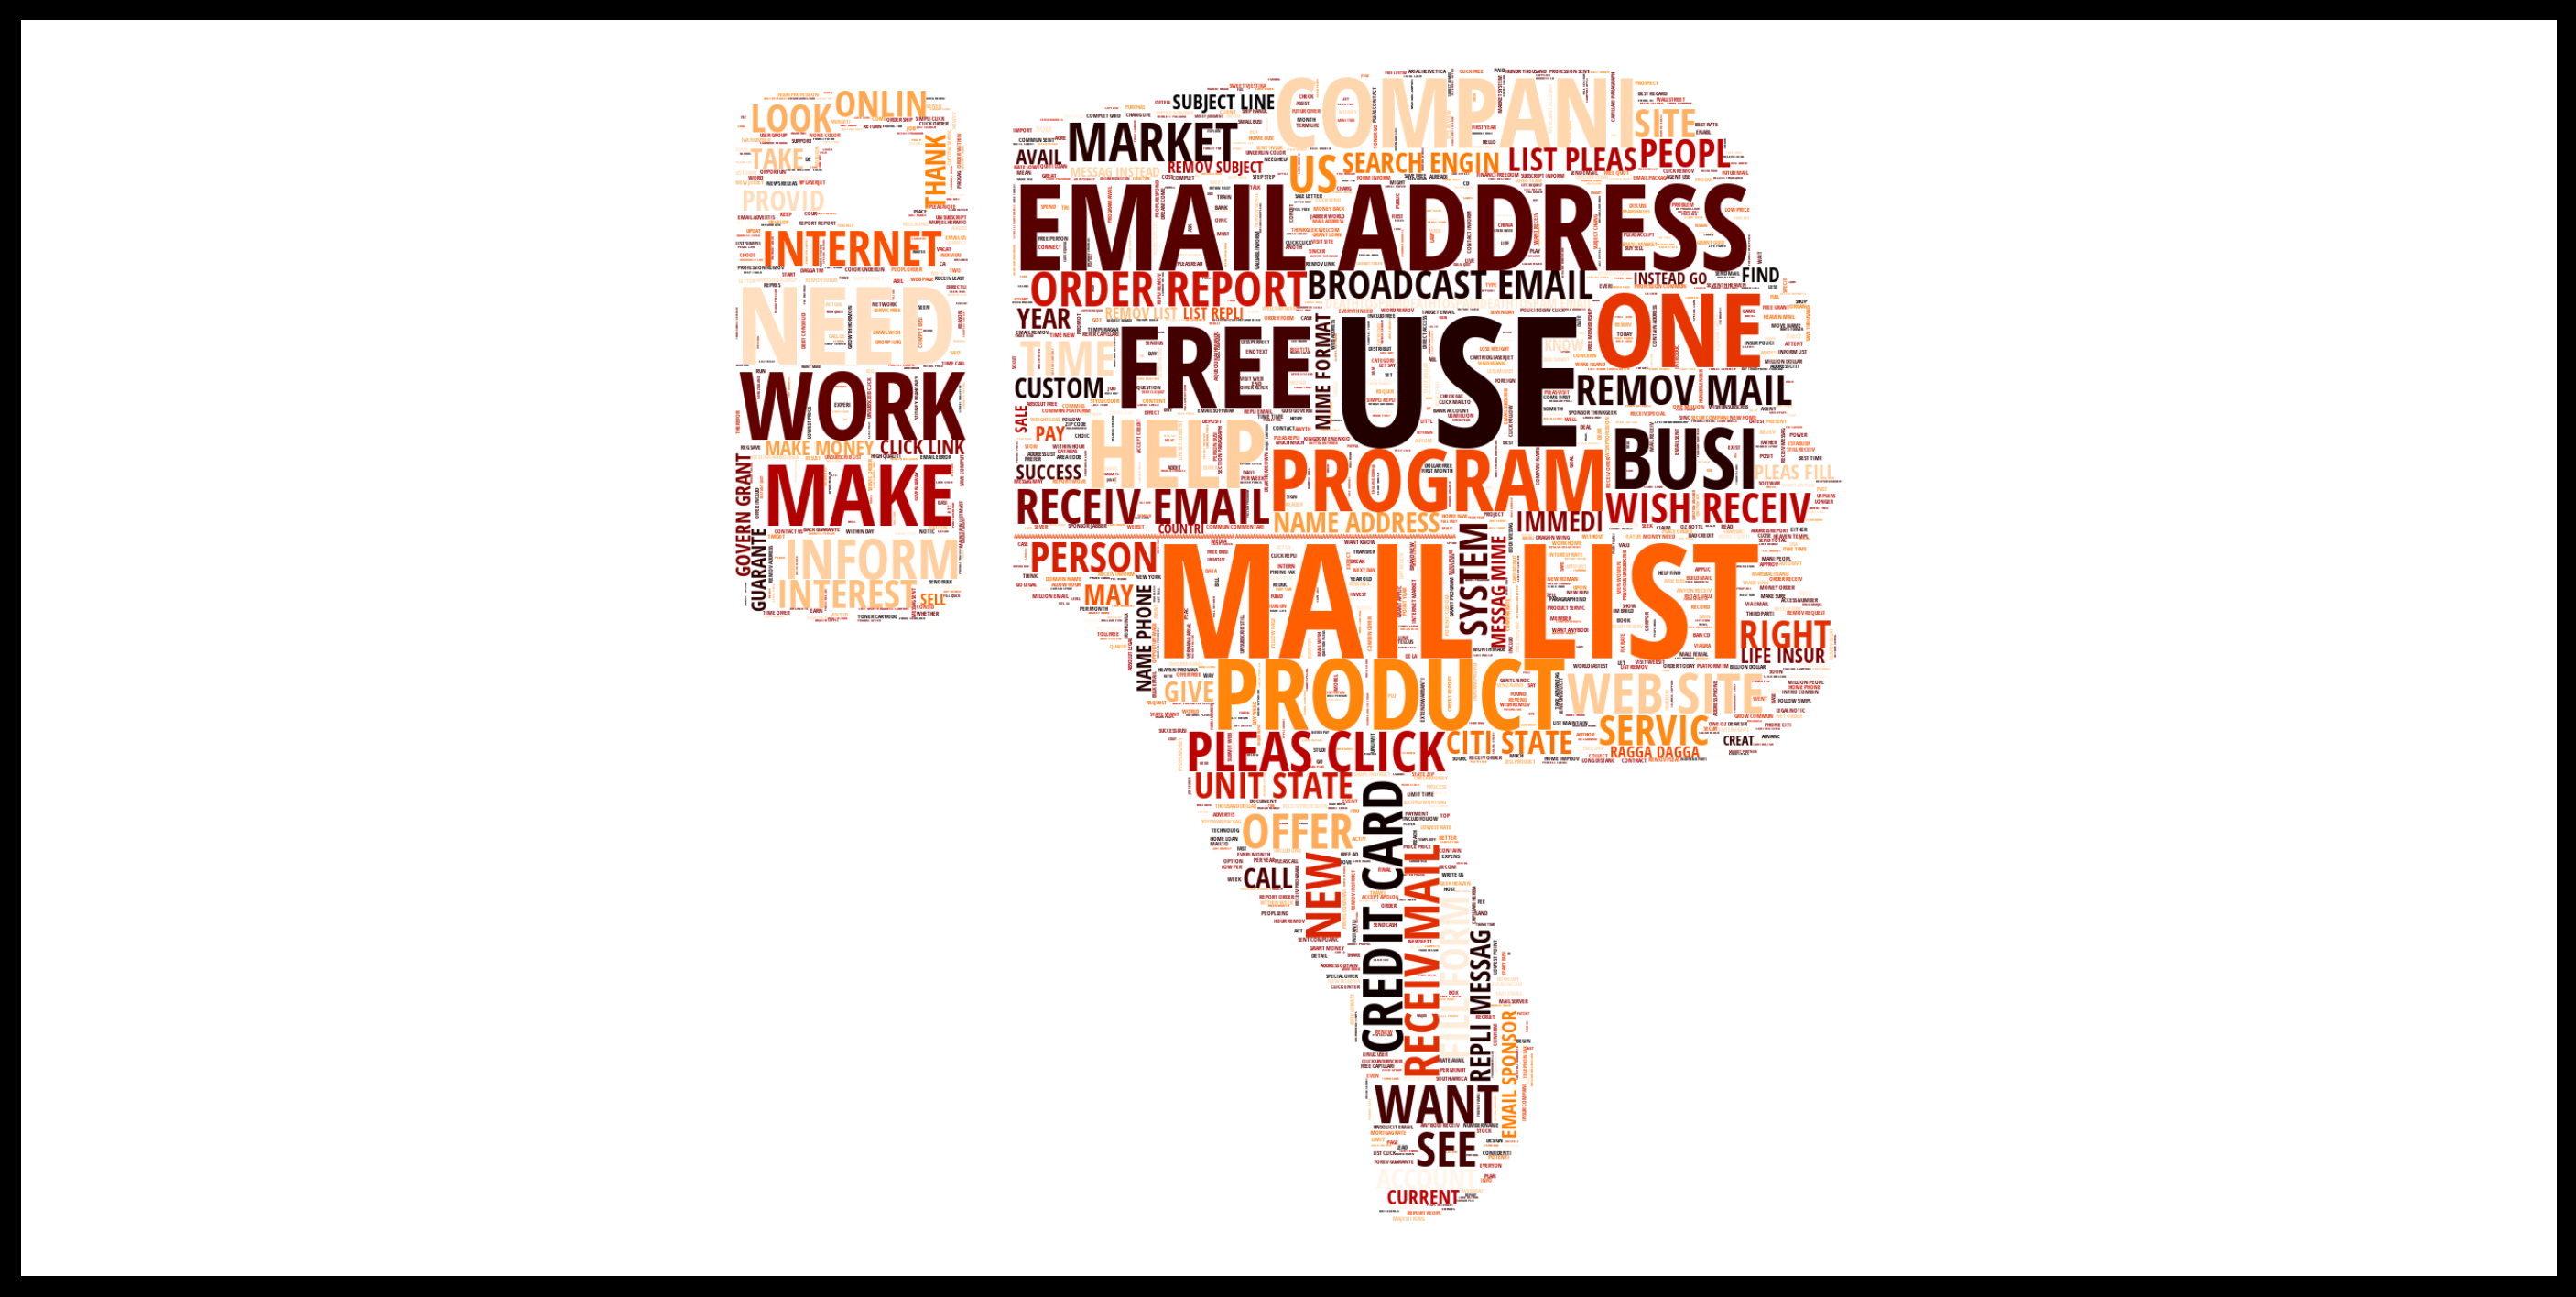

In [99]:
create_wordCloud(spam_emails_str,
                 mask_img=THUMBS_DOWN_FILE,
                 font_path=FONT_FILE,
                 colormap='gist_heat',
                 background_color='white',
                 max_words=2000)

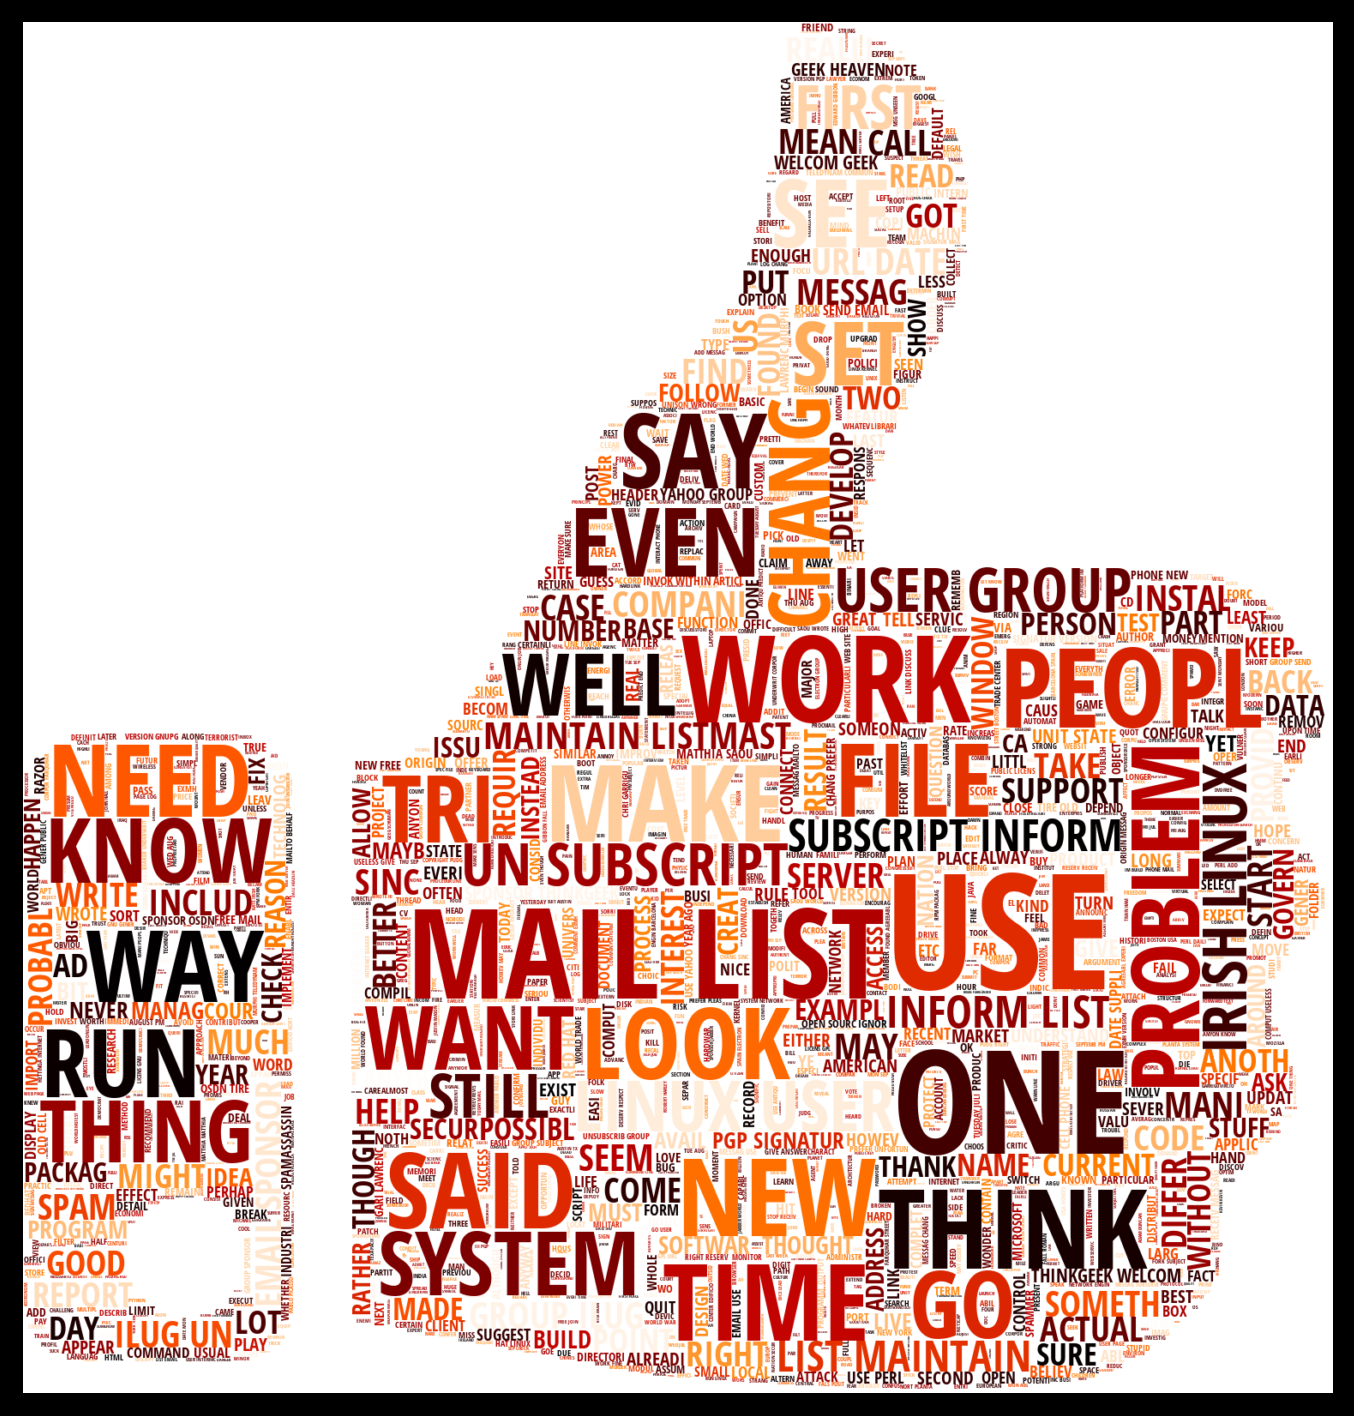

In [100]:
create_wordCloud(ham_emails_str, 
                 mask_img=THUMBS_UP_FILE,
                 font_path=FONT_FILE,
                 colormap='gist_heat',
                 background_color='white',
                 max_words=2000)

##### Generate Vocabulary & Dictionary

In [101]:
# flatten our nested list
flat_stemmed_lst = flatten_lst(nested_lst)

In [102]:
unique_words = pd.Series(flat_stemmed_lst).value_counts()

In [103]:
# print total number of unique words
print("Number of unique words", unique_words.shape[0])


Number of unique words 27294


In [104]:
frequent_words_method1 = unique_words[:2500]

In [105]:
frequent_words_method1

http           10662
use             5017
list            4852
email           4370
get             4187
               ...  
shoot             44
quarter           44
distributor       44
potent            44
advisor           44
Length: 2500, dtype: int64

In [106]:
# find the top 2500 most common words - method 2
frequent_words = find_most_common_words(nested_lst, top_n=2500)

In [107]:
frequent_words

http           10662
use             5017
list            4852
email           4370
get             4187
               ...  
shoot             44
quarter           44
distributor       44
potent            44
advisor           44
Length: 2500, dtype: int64

In [108]:
# print the top 10 of the most frequent_words

frequent_words[:10]

http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64


###### Create Vocabulary Dataframe with a WORD_ID

In [109]:
word_ids = list(range(0, VOCAB_SIZE)) # create ids of words ranging from 0 to 2500

# create a dataframe with a word and its index
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, # access the words by their indices
                     index=word_ids) # explicitly set index to be word_ids

vocab.index.name = 'WORD_ID' # set column name of indices

In [110]:
vocab.VOCAB_WORD.values[0]

'http'

##### Save Words By ID to CSV file

In [111]:
# save our data to CSV file

vocab.to_csv(WORD_ID_FILE, 
            index=vocab.index.name, # index = name of index in vocab dataframe
            header=vocab.VOCAB_WORD.name) # header = words in vocab dataframe

In [112]:
# Check if word is in vocab:
# use set!!!

def check_if_word_exists(word, collection_of_words):

  return word in set(collection_of_words)

In [113]:
print(check_if_word_exists('machine', vocab.VOCAB_WORD))
print(check_if_word_exists('learning', vocab.VOCAB_WORD))
print(check_if_word_exists('fun', vocab.VOCAB_WORD))
print(check_if_word_exists('learn', vocab.VOCAB_WORD))
print(check_if_word_exists('data', vocab.VOCAB_WORD))
print(check_if_word_exists('science', vocab.VOCAB_WORD))
print(check_if_word_exists('app', vocab.VOCAB_WORD))
print(check_if_word_exists('brewery', vocab.VOCAB_WORD))

False
False
True
True
True
False
True
False


In [114]:
nested_lst.values[0]

['immedi',
 'help',
 'need',
 'fortun',
 'compani',
 'grow',
 'tremend',
 'rate',
 'per',
 'year',
 'simpli',
 'keep',
 'look',
 'motiv',
 'individu',
 'look',
 'earn',
 'substanti',
 'incom',
 'work',
 'home',
 'real',
 'opportun',
 'make',
 'excel',
 'incom',
 'home',
 'experi',
 'requir',
 'provid',
 'train',
 'may',
 'need',
 'look',
 'energet',
 'self',
 'motiv',
 'peopl',
 'click',
 'link',
 'complet',
 'onlin',
 'inform',
 'request',
 'form',
 'one',
 'employ',
 'specialist',
 'contact',
 'http',
 'look',
 'employ',
 'home',
 'career',
 'provid',
 'vast',
 'opportun',
 'substanti',
 'incom',
 'pleas',
 'fill',
 'onlin',
 'inform',
 'request',
 'form',
 'http',
 'remov',
 'list',
 'simpli',
 'click',
 'link',
 'http']

In [115]:
# Find the Email with the Most Number of words

emails_len_lst = [len(email) for email in nested_lst] # list of email lengths

longest_email_len = max(emails_len_lst) # find the max length in length list

longest_email_index = emails_len_lst.index(longest_email_len) # find the index associated with that length

# you could also use argmax to find the index
# longest_email_index = np.argmax(emails_len_lst)


longest_email_body = nested_lst[longest_email_index] # print list of words at longest_email_index

In [116]:
print('The longest email is', longest_email_len, 'characters long')
print('The longest email occus at index: ', longest_email_index)
print('The longest email is: ', longest_email_body)

The longest email is 7661 characters long
The longest email occus at index:  5367
The longest email is:  ['yahoo', 'group', 'sponsor', 'dvd', 'free', 'p', 'join', 'http', 'new', 'version', 'unison', 'avail', 'test', 'incorpor', 'sever', 'small', 'improv', 'main', 'chang', 'fix', 'bug', 'potenti', 'seriou', 'safeti', 'consequ', 'small', 'number', 'user', 'habit', 'run', 'one', 'instanc', 'unison', 'time', 'parallel', 'user', 'strongli', 'encourag', 'upgrad', 'other', 'wait', 'wish', 'releas', 'includ', 'execut', 'linux', 'solari', 'window', 'look', 'maintain', 'moment', 'none', 'activ', 'develop', 'regularli', 'use', 'unison', 'window', 'machin', 'configur', 'properli', 'build', 'execut', 'export', 'grab', 'http', 'enjoy', 'benjamin', 'chang', 'sinc', 'ad', 'prefer', 'maxthread', 'use', 'limit', 'number', 'simultan', 'file', 'transfer', 'ad', 'backupdir', 'prefer', 'control', 'backup', 'file', 'store', 'basic', 'support', 'ad', 'osx', 'particular', 'unison', 'recogn', 'one', 'host', 'sy

In [117]:
data.at[np.argmax(emails_len_lst), 'MESSAGE'] # locate the longest email in data dataframe

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

##### Generate Features & a Sparse Matrix

###### Creating a Dataframe with one word per column

In [118]:
type(nested_lst)

pandas.core.series.Series

In [119]:
# first convert our series into a list
converted_nested_lst = nested_lst.to_list()

# next convert to pandas Dataframe
word_columns_df = pd.DataFrame.from_records(converted_nested_lst)

In [120]:
word_columns_df

0         1       2       3     ...  7657  7658  7659  7660
0      immedi      help    need  fortun  ...  None  None  None  None
1        save  thousand  dollar   cours  ...  None  None  None  None
2      regist    domain     new  domain  ...  None  None  None  None
3      messag      mime  format    high  ...  None  None  None  None
4      messag      mime  format  bassey  ...  None  None  None  None
...       ...       ...     ...     ...  ...   ...   ...   ...   ...
5791   messag    mailto  behalf   craig  ...  None  None  None  None
5792     http      post     thu     jul  ...  None  None  None  None
5793      tue       aug   niall   bradi  ...  None  None  None  None
5794  comment   probabl     goe  better  ...  None  None  None  None
5795     past       day    noth  report  ...  None  None  None  None

[5796 rows x 7661 columns]

In [121]:
word_columns_df.shape # width=totalEmails x length(columns)=lengthOfLongestEmail

(5796, 7661)

##### Splitting the Data into a Training and Test Dataset

In [122]:
# training data = 70%, test data = 30%
# seed value of 42
# features = dataframe of all our words
# target variable = category column in data dataframe
# X_train and y_train match up
# X_tets and y_test match up
X_train, X_test, y_train, y_test = train_test_split(word_columns_df,
                                                    data.CATEGORY,
                                                    test_size=0.3,
                                                    random_state=42)

In [123]:
# add index name to X_train and X_test
X_train.index.name = X_test.index.name = 'DOC_ID'

X_train.head()

0       1          2           3     ...  7657  7658  7659  7660
DOC_ID                                          ...                        
4844      rohit  wonder  microsoft     definit  ...  None  None  None  None
4727      sound      cw       leav  girlfriend  ...  None  None  None  None
5022       lanc  realli       like      ximian  ...  None  None  None  None
3504        use    exmh   procmail     presort  ...  None  None  None  None
3921    multipl   gener     cultiv        live  ...  None  None  None  None

[5 rows x 7661 columns]

In [124]:
X_train.index[3]

3504

In [125]:
# X_train.index[0]

len(X_train.iloc[0])

7661

In [126]:
# print(X_train.iloc[0][1])
# i = 0
# for item in X_train.iloc[0]:

#   print (item)

#   if item == None:

#     break

i = 0

while X_train.iloc[0][i] != None:

  print (X_train.iloc[0][i])

  i+=1

rohit
wonder
microsoft
definit
chief
softwar
architect
consequ
microsoft
think
roadmap
go
ballmer
gillmor
fork
architectur
war
love
hate
least
microsoft
understand
chief
sa
billg
overse
product
strategi
two
thing
road
map
one
piec
paper
tell
everyon
record
bunch
plan
someth
impos
broadli
vision
top
go
tri
get
everyth
share
path
get
everyth
stop
time
tri
take
top
four
five
thing
tri
longhorn
wave
yukon
wave
wave
realli
enough
time
discuss
make
happen
bill
gate
dedic
chief
softwar
architect
also
happen
chairman
compani
spend
time
chief
softwar
architect
bodi
meet
everi
month
sltt
senior
leadership
technic
team
basic
top
peopl
involv
strategi
present
discuss
issu
bill
drive
process
wave
instanc
ask
scenario
want
get
right
product
group
togeth
bring
thing
front
sltt
peopl
talk
take
good
manag
peopl
talk
good
coach
get
peopl
like
larg
organ
thing
import
certain
level
import
thing
peopl
make
better
give
framework
work
harmoni
peopl
compani
bill
perspect
framework
technic
road
map
sltt
proces

In [127]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

##### Create a Sparse Matrix for the Training Data

In [128]:
# use X_train, y_train, and vocab words

# create a way to index inside our vocab dataframe
word_index = pd.Index(vocab.VOCAB_WORD)

In [129]:
type(X_train)

pandas.core.frame.DataFrame

In [130]:

'''
def make_sparse_matrix(dataframe, indexed_words, labels)

  dataframe: REQUIRED
             pandas dataframe

  indexed_words: REQUIRED
                 index of words ordered by word_id
           
  
  labels: REQUIRED
          which category to be classified in

  return value: a sparse matrix as a dataframe 
  recall, a sparse matrix will only contain words that 
                 
'''


def make_sparse_matrix(dataframe, indexed_words, labels):


  num_of_rows = dataframe.shape[0] # number of rows in input dataframe
  num_of_columns = dataframe.shape[1] # number of columns in input dataframe
  word_set = set(indexed_words) # set of unique words to check for membership 

  dict_lst = []

  for i in range(num_of_rows):

    for j in range(num_of_columns):

      word = dataframe.iat[i , j] # retrive word at given row and column 

      if word in word_set: # if word is in the word set
 
        doc_id = dataframe.index[i] # doc id is the corresponding index of row in dataframe
        word_id = indexed_words.get_loc(word) # word id = index of word in indexed words
        category = labels.at[doc_id] # spam vs not spam obtained from labels dataframe (y_train)

        # store retrieved information in dictionary
        item = {
            'LABEL': category,
            'DOC_ID': doc_id, 
            'OCCURENCE': 1,
            'WORD_ID': word_id
        }

        dict_lst.append(item)

  return pd.DataFrame(dict_lst) # convert dict_lst into pandas dataframe

In [131]:
%%time

sparse_train_dataframe = make_sparse_matrix(X_train, word_index, y_train)

CPU times: user 10min 52s, sys: 1.3 s, total: 10min 54s
Wall time: 10min 55s


In [132]:
sparse_train_dataframe

LABEL  DOC_ID  OCCURENCE  WORD_ID
0           0    4844          1     2020
1           0    4844          1      554
2           0    4844          1      638
3           0    4844          1      965
4           0    4844          1     1153
...       ...     ...        ...      ...
440094      1     860          1      291
440095      1     860          1       26
440096      1     860          1      126
440097      1     860          1      909
440098      1     860          1     2029

[440099 rows x 4 columns]

In [133]:
sparse_train_dataframe.head()

LABEL  DOC_ID  OCCURENCE  WORD_ID
0      0    4844          1     2020
1      0    4844          1      554
2      0    4844          1      638
3      0    4844          1      965
4      0    4844          1     1153

In [134]:
sparse_train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440099 entries, 0 to 440098
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   LABEL      440099 non-null  int64
 1   DOC_ID     440099 non-null  int64
 2   OCCURENCE  440099 non-null  int64
 3   WORD_ID    440099 non-null  int64
dtypes: int64(4)
memory usage: 13.4 MB


In [135]:
sparse_train_dataframe.tail()

LABEL  DOC_ID  OCCURENCE  WORD_ID
440094      1     860          1      291
440095      1     860          1       26
440096      1     860          1      126
440097      1     860          1      909
440098      1     860          1     2029

In [136]:
sparse_train_dataframe.shape

(440099, 4)

##### Combine Occurences with the Pandas groupby() Method

In [137]:
# for each doc_id (email), group together word_id and labels and show corresponding occurences

train_grouped = sparse_train_dataframe.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()

In [138]:
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      0       1              3
       2       1              1
       6       1              1
       9       1              1
       11      1              1

In [139]:
vocab.at[0, 'VOCAB_WORD']

'http'

The first word at doc_id = 0 corresponds to the word "http" in the vocab dataframe and it occurs three times.

In [140]:
data.MESSAGE[0]

'Immediate Help Needed.  We are a fortune 500 company that is \n\ngrowing at a tremendous rate of over 1000% per year. We simply cannot \n\nkeep up. We are looking for motivated individuals who are looking to \n\nearn a substantial income working from home. \n\n\n\nThis is a real opportunity to make an excellent income from home. No \n\nexperience is required.  We will provide you with any training you may need. \n\n\n\nWe are looking for energetic and self motivated people.  If that is you \n\nthan click on the link below and complete our online information request \n\nform, \n\nand one of our employment specialist will contact you. \n\n\n\nhttp://ter.netblah.com:8080\n\n\n\nSo if you are looking to be employed at home, with a career that will \n\nprovide you vast opportunities and a substantial income, please fill \n\nout our online information request form here now: \n\n\n\nhttp://www.zhoster.com:8080/homeopp/ \n\n\n\n\n\nTo be removed from our list simply click on the link below no

In [141]:
train_grouped.tail()

OCCURENCE
DOC_ID WORD_ID LABEL           
5795   331     0              1
       344     0              1
       367     0              1
       388     0              1
       499     0              1

In [142]:
train_grouped = train_grouped.reset_index() # will have doc_id show on every row
train_grouped.head()

DOC_ID  WORD_ID  LABEL  OCCURENCE
0       0        0      1          3
1       0        2      1          1
2       0        6      1          1
3       0        9      1          1
4       0       11      1          1

In [143]:
train_grouped.tail()

DOC_ID  WORD_ID  LABEL  OCCURENCE
260873    5795      331      0          1
260874    5795      344      0          1
260875    5795      367      0          1
260876    5795      388      0          1
260877    5795      499      0          1

In [144]:
vocab.at[343, 'VOCAB_WORD']

'member'

In [145]:
data.MESSAGE[5795]

"For the past 2 days, nothing that I'm reporting seems to be in the\n\ndatabase.  If I report something, and the check the response is coming\n\nback as none spam.  Is anyone else seeing this?\n\n\n\n\n\n-------------------------------------------------------\n\nThis sf.net email is sponsored by:ThinkGeek\n\nWelcome to geek heaven.\n\nhttp://thinkgeek.com/sf\n\n_______________________________________________\n\nRazor-users mailing list\n\nRazor-users@lists.sourceforge.net\n\nhttps://lists.sourceforge.net/lists/listinfo/razor-users\n\n\n\n\n"

In [146]:
train_grouped.shape # reduced our dataset by 40%

(260878, 4)

###### Save Training File as .txt file

In [147]:
# use numpy to save to txt
np.savetxt(TRAINING_DATA_FILE, # location to save to
           train_grouped, # data
           fmt='%d') # format of data, hence %d

In [148]:
train_grouped.columns # column names 

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [190]:
train_grouped

DOC_ID  WORD_ID  LABEL  OCCURENCE
0            0        0      1          3
1            0        2      1          1
2            0        6      1          1
3            0        9      1          1
4            0       11      1          1
...        ...      ...    ...        ...
260873    5795      331      0          1
260874    5795      344      0          1
260875    5795      367      0          1
260876    5795      388      0          1
260877    5795      499      0          1

[260878 rows x 4 columns]

##### Create a Sparse Matrix for the Test Data

In [149]:
%%time

sparse_test_dataframe = make_sparse_matrix(X_test, word_index, y_test)

CPU times: user 4min 40s, sys: 454 ms, total: 4min 40s
Wall time: 4min 41s


In [150]:
# combine occurences with the pandas groupby() method

test_grouped = sparse_test_dataframe.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()

In [151]:
test_grouped = sparse_test_dataframe.reset_index()

In [154]:
# use numpy to save to txt
np.savetxt(TEST_DATA_FILE, # location to save to
           test_grouped, # data
           fmt='%d') # format of data, hence %d

In [162]:
test_grouped

index  LABEL  DOC_ID  OCCURENCE  WORD_ID
0            0      0    4675          1     1099
1            1      0    4675          1     2244
2            2      0    4675          1      138
3            3      0    4675          1     1099
4            4      0    4675          1      893
...        ...    ...     ...        ...      ...
193867  193867      0    4354          1      471
193868  193868      0    4354          1     1314
193869  193869      0    4354          1        5
193870  193870      0    4354          1        2
193871  193871      0    4354          1        0

[193872 rows x 5 columns]

##### Preprocessing Subtelties

In [168]:
emails_in_txt = set(test_grouped.DOC_ID.unique())
emails_in_test = set(X_test.index.unique())

In [172]:
len(emails_in_test)

1739

In [177]:
count = len(emails_in_test) - len(emails_in_txt)

print(emails_in_test - emails_in_txt) # which emails were excluded 
print("Number of emails excluded in txt file is: ", count)

{192, 65, 450, 132, 69, 8, 491, 1292, 45, 497, 498, 625, 373, 759, 1211, 221, 927}
Number of emails excluded in txt file is:  17


In [182]:
data.MESSAGE[45]

'------=_NextPart_000_00A5_78C83A6B.A1543A16\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nMzU0NHRqVFIwLTM5NUZLa20zNjkyYUN6QjUtNDQ5cGVsMzANCjxodG1sPjxi\n\nb2R5IGxpbms9I0ZGRkYwMCB2bGluaz0jRkZGRjAwIGFsaW5rPSNGRkZGMDAg\n\ndGV4dD0jRkZGRjAwIGJnY29sb3I9IzAwMDAwMD4gPHRhYmxlIGJvcmRlckNv\n\nbG9yPSMwMDAwMDAgd2lkdGg9NjAwIGFsaWduPWNlbnRlciBiZ0NvbG9yPSM2\n\nNjk5MzMgYm9yZGVyPTM+PHRyPjx0ZCBhbGlnbj1taWRkbGU+PGZvbnQgZmFj\n\nZT1BcmlhbCxIZWx2ZXRpY2Esc2Fucy1zZXJpZj48YnI+IDxmb250IGNvbG9y\n\nPXdoaXRlIHNpemU9KzM+PGEgaHJlZj1odHRwOi8vd3d3Lnh4eG1hdGNoLm5l\n\ndC93ZXRiaXRzL2luZGV4Lmh0bT5XZXRiaXRzPC9hPjwvZm9udD48L2ZvbnQ+\n\nPGEgaHJlZj1odHRwOi8vd3d3Lnh4eG1hdGNoLm5ldC93ZXRiaXRzL2luZGV4\n\nLmh0bT4gPC9hPjxwPjxmb250IGZhY2U9QXJpYWwsSGVsdmV0aWNhLHNhbnMt\n\nc2VyaWYgY29sb3I9I2ZmZmYwMCBzaXplPTM+PGI+IEdvbGRlbiBTaG93ZXIg\n\nRXh0cmF2YWdhbnphPC9iPjwvZm9udD48Zm9udCBmYWNlPUFyaWFsLEhlbHZl\n\ndGljYSxzYW5zLXNlcmlmPjxicj4gPGEgaHJlZj1odHRwOi8vd3d3Lnh4eG1h\n\ndGNoLm5ldC93ZXRiaXRzL2luZG

All the files that were excluded seem to be complete gibberish. Let's try to actually open the files and see what their contents are. A possible hypothesis for why these file contents are such is that maybe our encoding is incorrect.

In [184]:
data.loc[45] # find file name

MESSAGE      ------=_NextPart_000_00A5_78C83A6B.A1543A16\n\...
CATEGORY                                                     1
FILE_NAME               00180.13a95a2542a0fd01ff24303561cca949
Name: 45, dtype: object

When you open the file you see a one-to-one match, meaning that indeed the file is gibberish and that there is nothing wrong with the encoding.

In [188]:
clean_message(message=data.at[45, 'MESSAGE'])

[]

Because we are checking for membership in our clean_message function to only include words that are in the top 2500 most common words, these emails that are nonsensical do not get included in our sparse matrix as they contain no common words in their email bodies.